## Import Dependencies

In [11]:
import glob
import shutil
import matplotlib
import torch.utils
import torch.utils.data
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from configs.general import EXPERIMENT_BASE_DIR, EXPERIMENT_INFO_PATH, \
    EXPERIMENT_COLS, DEVICE, FILTERING_EXPERIMENT_INFO_PATH, FILTERING_EXPERIMENT_BASE_DIR, FILTERING_EXPERIMENT_COLS
from model import get as get_model
from configs import configs
from data.set import  GeneralDataset
from plottable import ColumnDefinition
from plottable import Table
from torchvision import transforms as t
from plottable.cmap import normed_cmap
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torch.nn.functional import softmax
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

## Calculate test accuracy for done experiments 

In [ ]:
from configs.cifar10 import Config as Cifar10Config
transform = t.Compose([
        t.ToTensor(),
        t.Normalize(mean=Cifar10Config.mean, std=Cifar10Config.std),
    ])


shutil.copy(EXPERIMENT_INFO_PATH, EXPERIMENT_INFO_PATH+".swp")
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = experiments[(experiments['done'] == True) & (experiments['test_acc'].isna())]

while not target_experiments.empty:
    target_experiments = experiments[(experiments['done'] == True) & (experiments['test_acc'].isna())]
    print('TODO: ',len(target_experiments))
    for index, row in target_experiments.head(10).iterrows():
        test_acc = []
        for fold in range(row['folds']):
            experitment_dir = osp.join(EXPERIMENT_BASE_DIR, *[row[col] for col in EXPERIMENT_COLS], str(fold))
            glob_regex = osp.join(experitment_dir, '*best_model.pt')
            model_path = sorted(glob.glob(glob_regex))[0]
            model = get_model(name=row['model'], num_classes=len(configs[row['dataset']].classes)) 
            model.load_state_dict(torch.load(model_path))
            model.to(DEVICE)

            test_dataset = GeneralDataset(dataset_name=row['dataset'], label_column='true_label', phase='test', transform=transform)
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
            model.eval()

            all_labels = []
            all_predictions = []
            with torch.no_grad():
                validation_epoch_loss = []
                iteration = 0
                for idx, data, labels in test_loader:
                    data, labels = data.to(DEVICE), labels.to(DEVICE)
                    prediction_values = model(data)  # (B, C)
                    prediction_probs = softmax(prediction_values, dim=1)  # (B, C)

                    all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())
                    all_predictions.extend(torch.max(prediction_probs, 1)[1].cpu().numpy())

            # Calculate overall accuracy
            overall_accuracy = (accuracy_score(all_labels, all_predictions) * 100).round(2)
            test_acc.append(overall_accuracy)
        print('test_acc: ', test_acc)
        print('---index: ', index)
        experiments.at[index, 'test_acc'] = f"{test_acc[0]} {test_acc[1]} {test_acc[2]}"
    experiments.to_csv(EXPERIMENT_INFO_PATH)


### Best test acc all

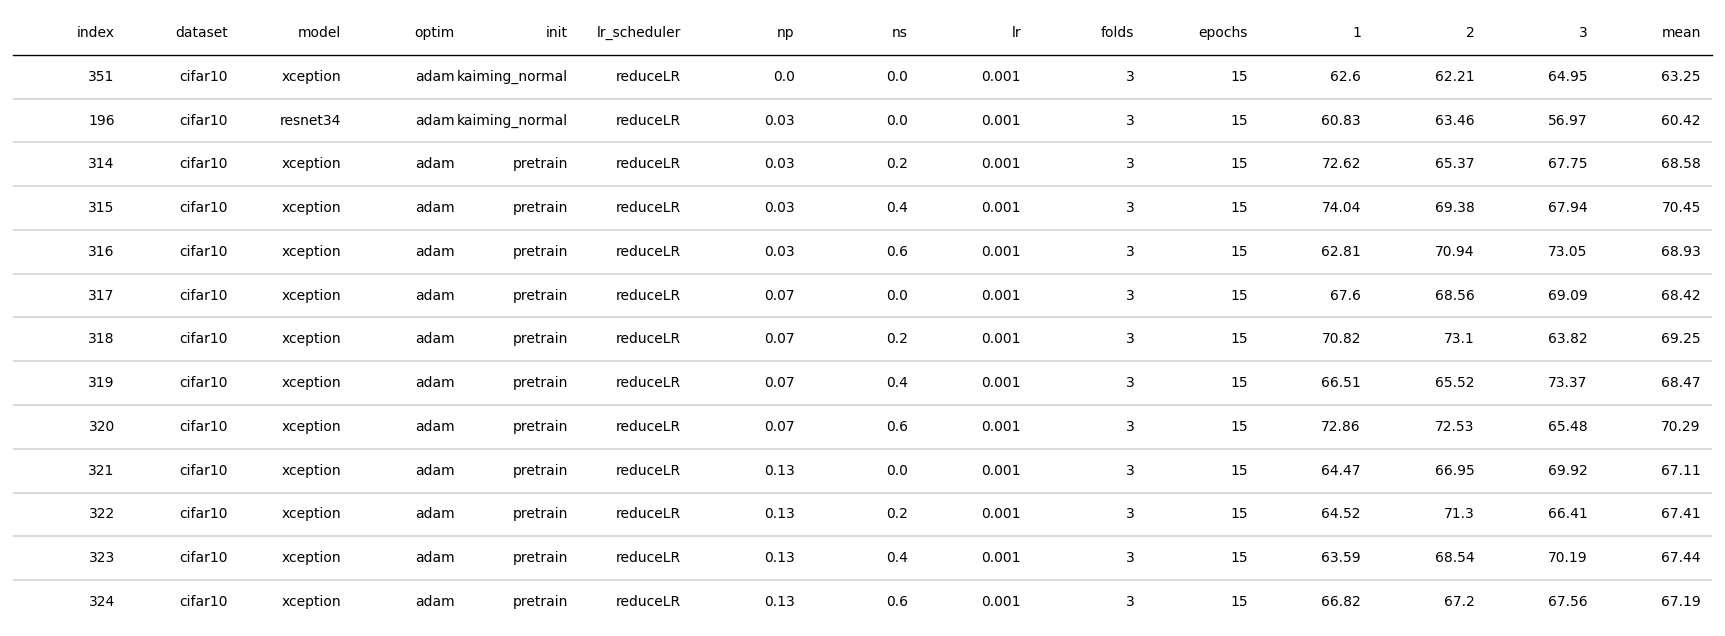

In [31]:

target_experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = target_experiments[(target_experiments['done'] == True) & (~target_experiments['test_acc'].isna())]
result = pd.DataFrame()
for index, row in target_experiments.iterrows():
    test_acc = [float(x) for x in row['test_acc'].split()]
    target_experiments.at[index, '1'] = test_acc[0]
    target_experiments.at[index, '2'] = test_acc[1]
    target_experiments.at[index, '3'] = test_acc[2]
    target_experiments.at[index, 'mean'] = np.mean(test_acc).round(2)

max_ids = target_experiments.groupby(['np', 'ns'])['mean'].idxmax()
table = target_experiments.loc[max_ids]
table['np'] = table['np'].str.replace('np=', '').astype(float)
table['ns'] = table['ns'].str.replace('ns=', '').astype(float)
table['lr'] = table['lr'].str.replace('lr=', '').astype(float)
table = table.drop(columns=['test_acc', 'done'])
# print(z.head())


# Init a figure
fig, ax = plt.subplots(figsize=(22, 8))
tab = Table(table)
plt.show()

## Calculate test accuracy for done filtering experiments 

In [ ]:
from configs.cifar10 import Config as Cifar10Config
transform = t.Compose([
        t.ToTensor(),
        t.Normalize(mean=Cifar10Config.mean, std=Cifar10Config.std),
    ])

shutil.copy(FILTERING_EXPERIMENT_INFO_PATH, FILTERING_EXPERIMENT_INFO_PATH+".swp")
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
filtering_experiments = pd.read_csv(FILTERING_EXPERIMENT_INFO_PATH, index_col='index')

target_experiments = filtering_experiments[(filtering_experiments['done'] == True) & (filtering_experiments['test_acc'].isna())]

while not target_experiments.empty:
    target_experiments = filtering_experiments[(filtering_experiments['done'] == True) & (filtering_experiments['test_acc'].isna())]
    print('TODO: ',len(target_experiments))
    for index, row in target_experiments.head(10).iterrows():
        bex = row['basic_experiment_index']
        test_acc = []
        for fold in range(experiments.iloc[bex]['folds']):
            experitment_dir = osp.join(FILTERING_EXPERIMENT_BASE_DIR, *[str(row[col]) for col in FILTERING_EXPERIMENT_COLS], str(fold))
            glob_regex = osp.join(experitment_dir, '*best_model.pt')
            print('glob_regex: ', glob_regex)
            print('glob.glob(glob_regex): ', glob.glob(glob_regex))
            model_path = sorted(glob.glob(glob_regex))[0]
            model = get_model(name=experiments.iloc[bex]['model'], num_classes=len(configs[experiments.iloc[bex]['dataset']].classes))
            model.load_state_dict(torch.load(model_path))
            model.to(DEVICE)

            test_dataset = GeneralDataset(dataset_name=experiments.iloc[bex]['dataset'], label_column='true_label', phase='test', transform=transform)
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
            model.eval()

            all_labels = []
            all_predictions = []
            with torch.no_grad():
                validation_epoch_loss = []
                iteration = 0
                for idx, data, labels in test_loader:
                    data, labels = data.to(DEVICE), labels.to(DEVICE)
                    prediction_values = model(data)  # (B, C)
                    prediction_probs = softmax(prediction_values, dim=1)  # (B, C)

                    all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())
                    all_predictions.extend(torch.max(prediction_probs, 1)[1].cpu().numpy())

            # Calculate overall accuracy
            overall_accuracy = (accuracy_score(all_labels, all_predictions) * 100).round(2)
            test_acc.append(overall_accuracy)
        print('test_acc: ', test_acc)
        print('---index: ', index)
        filtering_experiments.at[index, 'test_acc'] = f"{test_acc[0]} {test_acc[1]} {test_acc[2]}"
    filtering_experiments.to_csv(FILTERING_EXPERIMENT_INFO_PATH)


### Best test acc all

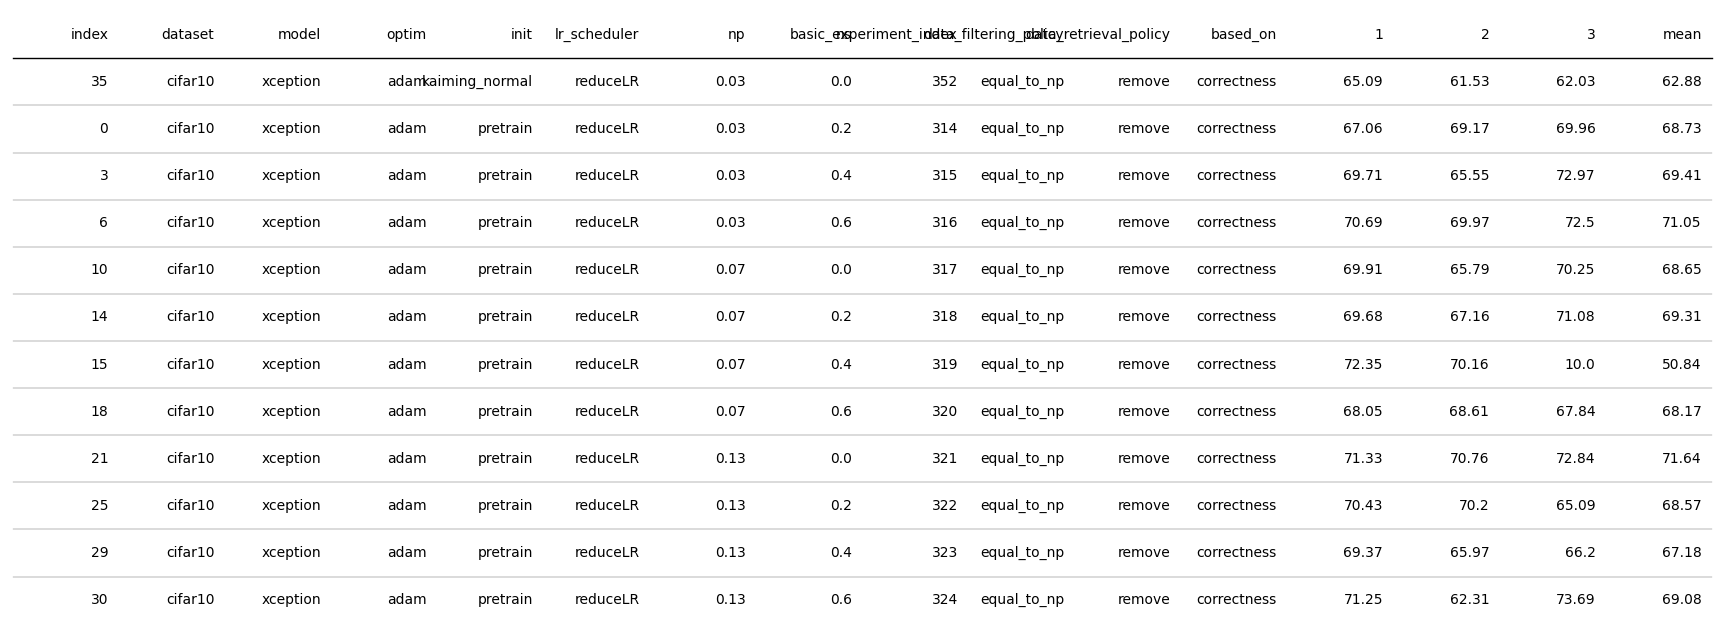

In [50]:

filtering_experiments = pd.read_csv(FILTERING_EXPERIMENT_INFO_PATH, index_col='index')
filtering_experiments = filtering_experiments[filtering_experiments['done'] == True]

target_experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = target_experiments.iloc[np.unique(filtering_experiments['basic_experiment_index'])]
target_experiments = target_experiments[['dataset', 'model', 'optim', 'init', 'lr_scheduler', 'np', 'ns']]
merged_df = pd.merge(left=target_experiments, right=filtering_experiments, left_index=True, right_on="basic_experiment_index")
result = pd.DataFrame()
for index, row in merged_df.iterrows():
    test_acc = [float(x) for x in row['test_acc'].split()]
    merged_df.at[index, '1'] = test_acc[0]
    merged_df.at[index, '2'] = test_acc[1]
    merged_df.at[index, '3'] = test_acc[2]
    merged_df.at[index, 'mean'] = np.mean(test_acc).round(2)

max_ids = merged_df.groupby(['np', 'ns'])['mean'].idxmax()
table = merged_df.loc[max_ids]
table['np'] = table['np'].str.replace('np=', '').astype(float)
table['ns'] = table['ns'].str.replace('ns=', '').astype(float)
table = table.drop(columns=['test_acc', 'done'])

# Init a figure
fig, ax = plt.subplots(figsize=(22, 8))
tab = Table(table)
plt.show()